# Imports 

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import statistics
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import dataframe_image as dfi
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
import spacy
import umap
import fasttext
import fasttext.util
from gensim.models.fasttext import *
from sentence_transformers import SentenceTransformer
nlp = spacy.load('de_core_news_lg')
# sns.set_theme(style="darkgrid")

%matplotlib inline

In [364]:
pd.set_option('max_colwidth', None)

# Load Data

In [365]:
df = pd.read_csv(filepath_or_buffer = "./data/datframe_subtask1_2.csv")
df.head()

,tweet,binaereKlassifikation,granulareKlassifikation
0,@JanZimmHHB @mopo Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...,OFFENSE,INSULT
1,"@faznet @Gruene_Europa @SPDEuropa @CDU CDU steht seid Strauss, Kohl, Schäuble, vdLeyen für Korruption, Schwarzgeld, und dies überall...",OFFENSE,ABUSE
2,"@DLFNachrichten Die Gesichter, Namen, Religion der Täter würde zur Aufklärung beitragen...",OTHER,OTHER
3,"@welt Wie verwirrt muss man sein um sich zu weigern die Tatsachen anzuerkennen, das dieser Hass von Ferkel importiert wurde....was bezweckt man damit sich selber so zu belügen, unverständlich",OFFENSE,ABUSE
4,"@hacker_1991 @torben_braga Weil die AfD den Ferkelfunk abschaffen will, deshalb haben die Linken Zecken, Schmarotzer Angst für ihr kacken arbeiten zu müssen, deshalb sind die Führer treu und senden jeden Dreck, Lüge...",OFFENSE,ABUSE


In [366]:
df.describe()

,tweet,binaereKlassifikation,granulareKlassifikation
count,3031,3031,3031
unique,3031,2,4
top,@JanZimmHHB @mopo Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...,OTHER,OTHER
freq,1,2061,2061


# Beschreibung des Datensatzes

## Beschreibung des Rohdatensatzes

In [367]:
df.iloc[:,1].value_counts()

OTHER      2061
OFFENSE     970
Name: binaereKlassifikation, dtype: int64

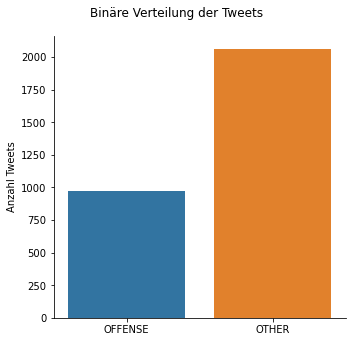

In [368]:
ax0 = sns.catplot(x="binaereKlassifikation", kind="count", data=df)

ax0.fig.suptitle('Binäre Verteilung der Tweets')
ax0.fig.subplots_adjust(top=0.9)
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")
plt.savefig("Verteilung_binaere_Klassifikation.png")
plt.show()

In [369]:
df.iloc[:,2].value_counts()

OTHER        2061
INSULT        459
ABUSE         400
PROFANITY     111
Name: granulareKlassifikation, dtype: int64

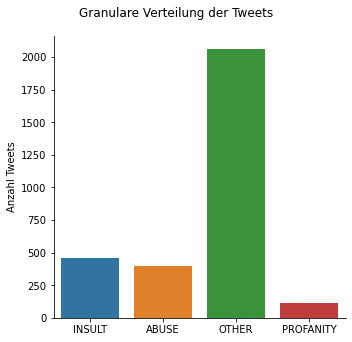

In [370]:
ax0 = sns.catplot(x="granulareKlassifikation", kind="count", data=df)

ax0.fig.suptitle('Granulare Verteilung der Tweets')
ax0.fig.subplots_adjust(top=0.9)
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")
plt.savefig("Verteilung_granulare_Klassifikation.png")
plt.show()

## Datenaufbereitung des Rohadatensatzes

In [371]:
buffer_array = df.iloc[:,0].to_numpy()
linked_list = []
hashtag_list = []
tweet_list = []
utf_list = []
emoji_list = []
w_o_punctuation_list = []

emoji_list_default = [":D",":)",":(",":/","B)","8)","xD","XD","^^","._."
              ,":-D",":-)",":-(",":-/","B-)","8-)","x-D","X-D",":'-("]

stop_words = ["|LBR|"," ",""]



for i in buffer_array:
    help_array_linked = []
    help_array_hash = []
    help_array_utf = []
    help_array_emoji = []
    help_array_w_o_punctuaton = []
    
    word_list = i.split(" ")
    index_count = 0
    for i in word_list:
        if i.startswith('\\"'): 
            help_list = i.split('\\""')
            for l in help_list:
                if l != '':
                    word_list[index_count] = l
                    break
        if word_list[index_count].startswith('*') and word_list[index_count].endswith('*'):
            word_list[index_count] = i.replace('*', ' ')
        if '&amp;' in word_list[index_count]:
            word_list[index_count] = i.replace('&amp;', 'und')
        if '&lt;3' in word_list[index_count]:
            word_list[index_count] = i.replace('&lt;3', '<3')
        if '&lt;' in word_list[index_count]:
            word_list[index_count] = i.replace('&lt;', 'kleiner als')
        if '&rt;' in word_list[index_count]:
            word_list[index_count] = i.replace('&rt;', 'groesser als')
        if "@" in i:
            help_array_linked.append(i)
        if "#" in i:
            help_array_hash.append(i)
            word_list[index_count] = i.replace("#","")
        if "<U+" in i:
            buffer = i.split("<")
            i = buffer[0]
#             buffer[1]=utf
            word_list[index_count] = i
            for code in buffer[1:]:
                if code[0]!="<":
                    code = "<"+code
                help_array_utf.append(code)
        if i in emoji_list_default:
            help_array_emoji.append(i)
        if i in stop_words:
            word_list.remove(i)

        index_count = index_count+1
        
    for i in help_array_linked:
        word_list.remove(i)
    for i in help_array_emoji:
        word_list.remove(i)
    for i in word_list:
        buffer_word = i.translate(str.maketrans('', '', string.punctuation))
        help_array_w_o_punctuaton.append(buffer_word)
    

        
        
    linked_list.append(help_array_linked)
    hashtag_list.append(help_array_hash)
    tweet_list.append(word_list)
    utf_list.append(help_array_utf)
    emoji_list.append(help_array_emoji)
    w_o_punctuation_list.append(help_array_w_o_punctuaton)

df["Wörter in Tweet"] = tweet_list
df["Wörter pro Tweet"]="-"
df["Tweets ohne Satzzeichen"] = w_o_punctuation_list
df["Wortlänge"] = "-"
df["Durchschnittliche Wortlänge"] = "-"
df["Verlinkungen"]=linked_list
df["Verlinkung pro Tweet"] =  "-"
df["Hashtags"]=hashtag_list
df["Hashtags pro Tweet"] =  "-"
df["utf Codes"]=utf_list
df["utf Codes pro Tweet"] =  "-"
df["Emojis"] = emoji_list
df["Emojis pro Tweet"] =  "-"


In [372]:
# new function to clean tweets
def clean_tweets(tweets: str): 
    replace_dict = {"*": " ",
                   "*amp;": "und",
                   '&lt;3': '<3',
                   '&lt;': 'kleiner als',
                   '&rt;': 'groesser als',
                    "#": "",
                    "<U+": "",
                    "|LBR|": ""
                   }

    tweet_list = []
    for tweet in tweets:
        words_list = tweet.split(" ")
        tweet_words = []
        for word in words_list:
            for key, value in replace_dict.items():
                word = word.replace(key, value)
            if not "@" in word and not "#" in word:
                tweet_words.append(word)
        tweet_list.append(tweet_words)
    
    return tweet_list

In [373]:
for index, row in df.iterrows():
    word_list = row["Wörter in Tweet"]
    char_list = row["Tweets ohne Satzzeichen"]
    link_list = row["Verlinkungen"]
    hash_list = row["Hashtags"]
    utf_list  = row["utf Codes"]
    emoj_list = row["Emojis"]
    
    word_count = len(word_list)
    link_count = len(link_list)
    hash_count = len(hash_list)
    utf_count  = len(utf_list)
    emoj_count = len(emoj_list)
    
    char_array = []
    
    for i in char_list:
        char_array.append(len(i))
    avg_length = round(statistics.mean(char_array),2)
    
    df.loc[index,"Wörter pro Tweet"] = word_count
    df.loc[index,"Wortlänge"] = char_array
    df.loc[index,"Durchschnittliche Wortlänge"] = avg_length
    df.loc[index,"Verlinkung pro Tweet"] = link_count
    df.loc[index,"Hashtags pro Tweet"] = hash_count
    df.loc[index,"utf Codes pro Tweet"] = utf_count
    df.loc[index,"Emojis pro Tweet"] = emoj_count

In [374]:
for x in df['Wörter in Tweet']:
    index_count = 0
    for w in x:
        x[index_count] = w.lower()
        index_count = index_count + 1

## Analyse der quantitativen Merkmale

In [375]:
df[["Wörter pro Tweet","Durchschnittliche Wortlänge","Verlinkung pro Tweet","Hashtags pro Tweet","utf Codes pro Tweet","Emojis pro Tweet"]].astype(int).describe()

,Wörter pro Tweet,Durchschnittliche Wortlänge,Verlinkung pro Tweet,Hashtags pro Tweet,utf Codes pro Tweet,Emojis pro Tweet
count,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000
mean,20.415374,4.976905,1.547674,0.472121,0.365886,0.023755
std,12.006929,1.035410,2.714760,1.083844,1.155448,0.170700
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,5.000000,1.000000,0.000000,0.000000,0.000000
75%,31.000000,6.000000,2.000000,0.000000,0.000000,0.000000
max,71.000000,14.000000,17.000000,8.000000,32.000000,4.000000


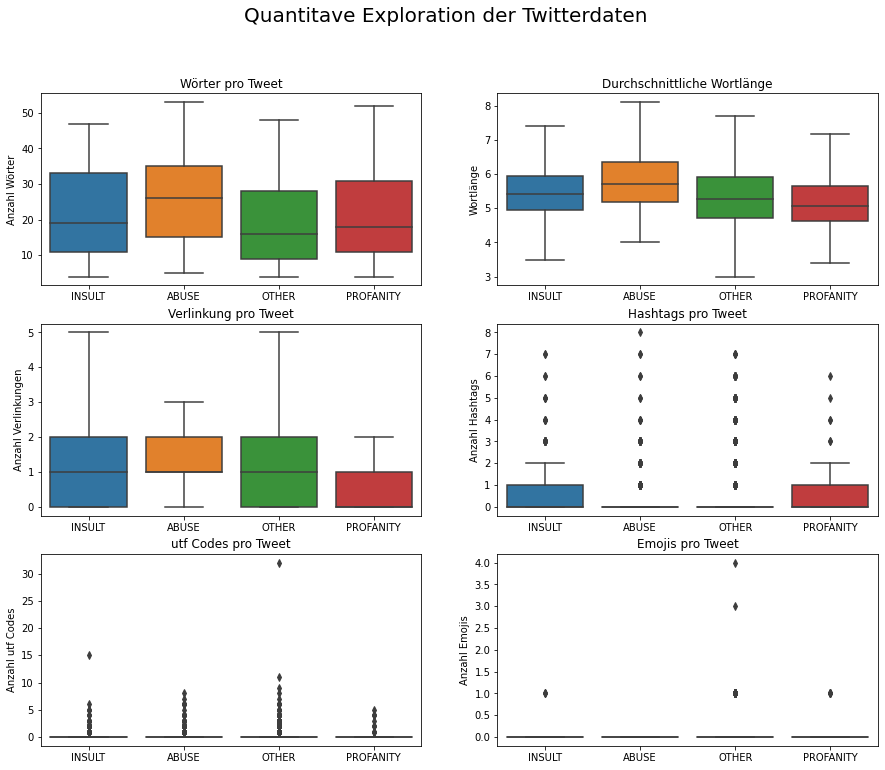

In [376]:
fig, axes = plt.subplots(nrows = 3
                         ,ncols = 2
                         ,figsize=(15,12)
                         ,sharex = False
                        )

fig.suptitle("Quantitave Exploration der Twitterdaten", fontsize=20)

ax0 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "Wörter pro Tweet"
                  ,showfliers = False
                  ,ax = axes[0,0]
                 )

ax0.set_title("Wörter pro Tweet", fontsize = 12)
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Wörter")

ax1 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "Durchschnittliche Wortlänge"
                  ,showfliers = False
                  ,ax = axes[0,1]
                 )
ax1.set_title("Durchschnittliche Wortlänge", fontsize = 12)
ax1.set(xlabel  = ""
        ,ylabel = "Wortlänge")


ax2 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "Verlinkung pro Tweet"
                  ,showfliers = False
                  ,ax = axes[1,0]
                 )

ax2.set_title("Verlinkung pro Tweet", fontsize = 12)
ax2.set(xlabel  = ""
        ,ylabel = "Anzahl Verlinkungen")

ax3 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "Hashtags pro Tweet"
#                   ,showfliers = False
                  ,ax = axes[1,1]
                 )

ax3.set_title("Hashtags pro Tweet", fontsize = 12)
ax3.set(xlabel  = ""
        ,ylabel = "Anzahl Hashtags")

ax4 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "utf Codes pro Tweet"
#                   ,showfliers = False
                  ,ax = axes[2,0]
                 )

ax4.set_title("utf Codes pro Tweet", fontsize = 12)
ax4.set(xlabel  = ""
        ,ylabel = "Anzahl utf Codes")

ax5 = sns.boxplot(data = df
                  ,x = "granulareKlassifikation"
                  ,y = "Emojis pro Tweet"
#                   ,showfliers = False
                  ,ax = axes[2,1]
                 )

ax5.set_title("Emojis pro Tweet", fontsize = 12)
ax5.set(xlabel  = ""
        ,ylabel = "Anzahl Emojis")

plt.savefig("Quantitave_Exploration.png")

plt.show()

### Anzahl Wörter pro Tweet

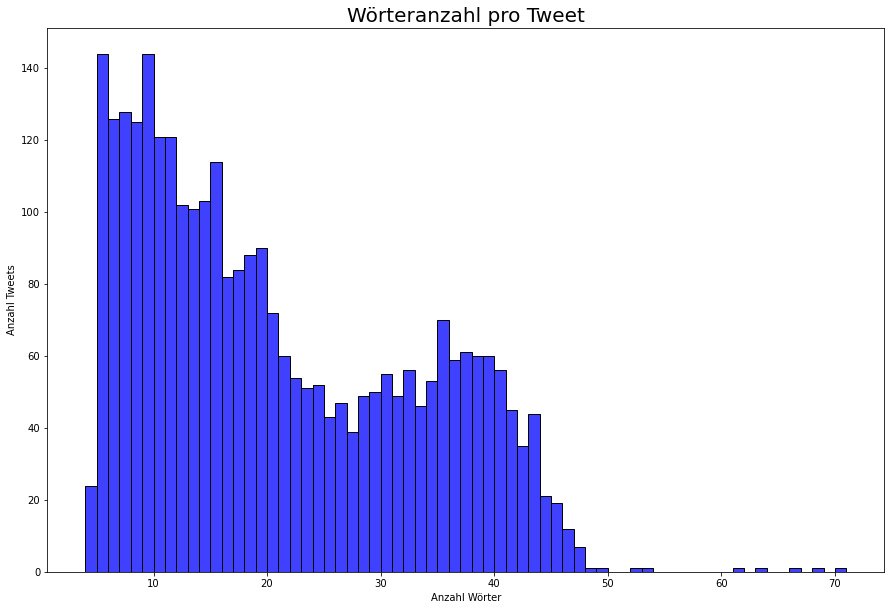

In [377]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.histplot(data = df
                   , x = "Wörter pro Tweet"
                   , color = "blue"
                   , stat = "count"
                   , binwidth = 1
              )

ax.set(xlabel  = "Anzahl Wörter"
        ,ylabel = "Anzahl Tweets")

plt.title('Wörteranzahl pro Tweet',size=20)
plt.savefig("Wörter_pro_Tweet_Gesamt.png")
plt.show()

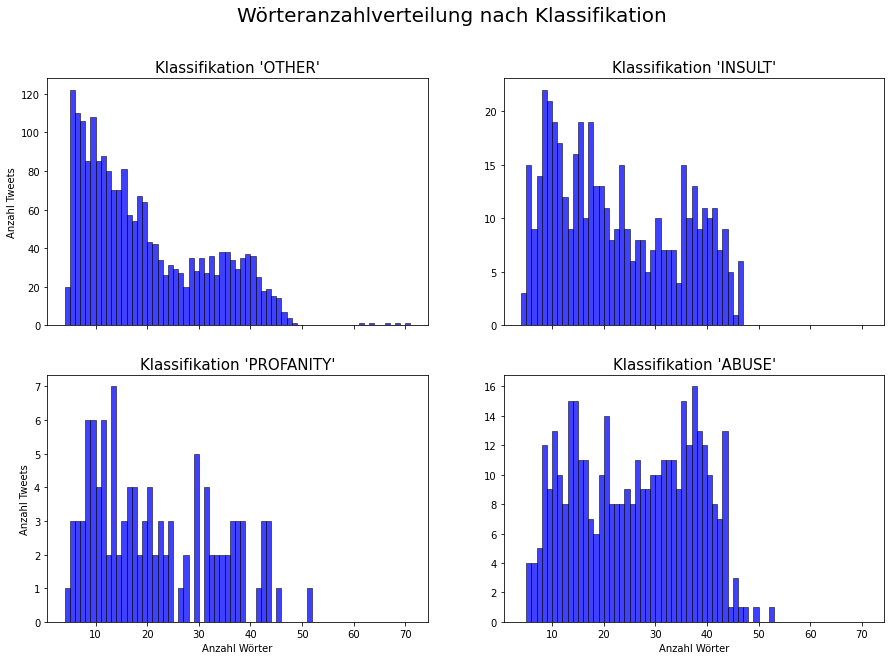

In [378]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Wörteranzahlverteilung nach Klassifikation", fontsize=20)

ax0 = sns.histplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "Wörter pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    ,ax = axes[0,0]
              )

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
# ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.histplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "Wörter pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    ,ax = axes[0,1]
              )

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
# ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.histplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "Wörter pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    ,ax = axes[1,0]
              )

ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
# ax2.set(xticklabels=[])
ax2.set(xlabel  = "Anzahl Wörter"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.histplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "Wörter pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    ,ax = axes[1,1]
              )

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Anzahl Wörter"
        ,ylabel = "")

plt.savefig("Wörter_pro_Tweet_Klassen.png")


plt.show()

### Durchschnittliche Wortlänge pro Tweet

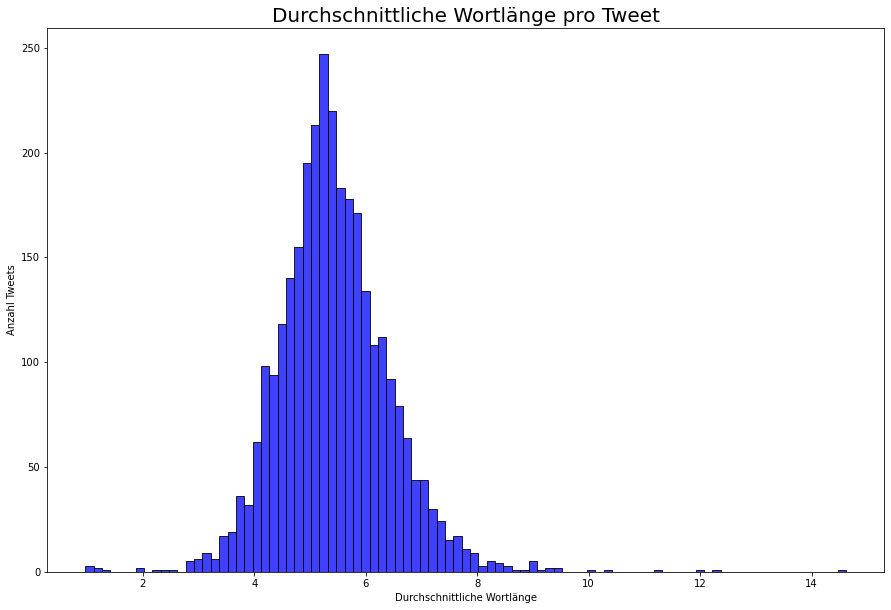

In [379]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.histplot(data = df
                 , x = "Durchschnittliche Wortlänge"
                 , color = "blue"
                 , stat = "count"
                 , binwidth = 0.15
              )

ax.set(xlabel  = "Durchschnittliche Wortlänge"
        ,ylabel = "Anzahl Tweets")

plt.title('Durchschnittliche Wortlänge pro Tweet',size=20)

plt.savefig("Wortlänge_pro_Tweet_Gesamt.png")

plt.show()

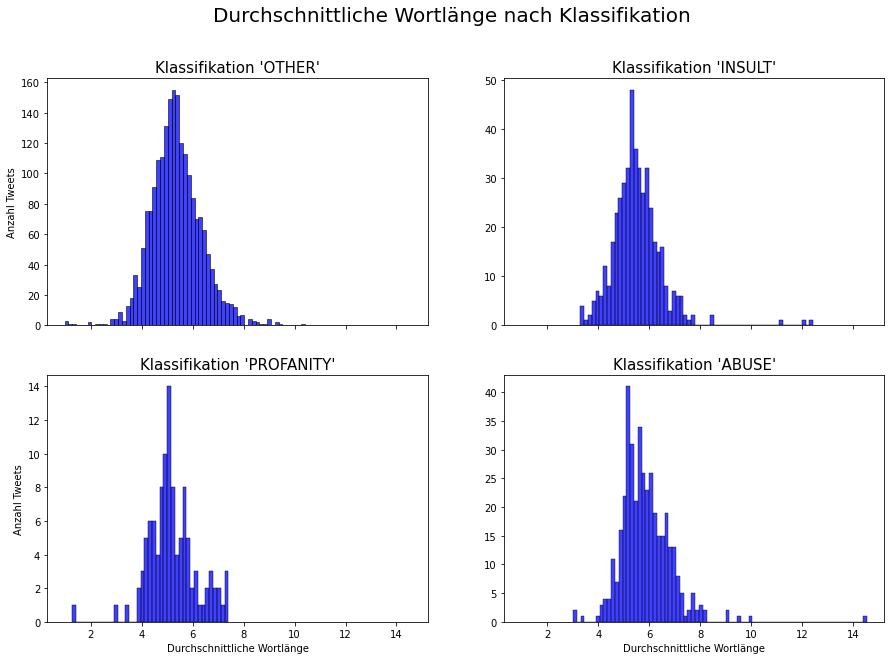

In [380]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Durchschnittliche Wortlänge nach Klassifikation", fontsize=20)

ax0 = sns.histplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "Durchschnittliche Wortlänge"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 0.15
                    ,ax = axes[0,0]
              )

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
# ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.histplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "Durchschnittliche Wortlänge"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 0.15
                    ,ax = axes[0,1]
              )

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
# ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.histplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "Durchschnittliche Wortlänge"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 0.15
                    ,ax = axes[1,0]
              )

ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
# ax2.set(xticklabels=[])
ax2.set(xlabel  = "Durchschnittliche Wortlänge"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.histplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "Durchschnittliche Wortlänge"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 0.15
                    ,ax = axes[1,1]
              )

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Durchschnittliche Wortlänge"
        ,ylabel = "")

plt.savefig("Wortlänge_pro_Tweet_Klassen.png")

plt.show()

### Anzahl Verlinkungen pro Tweet

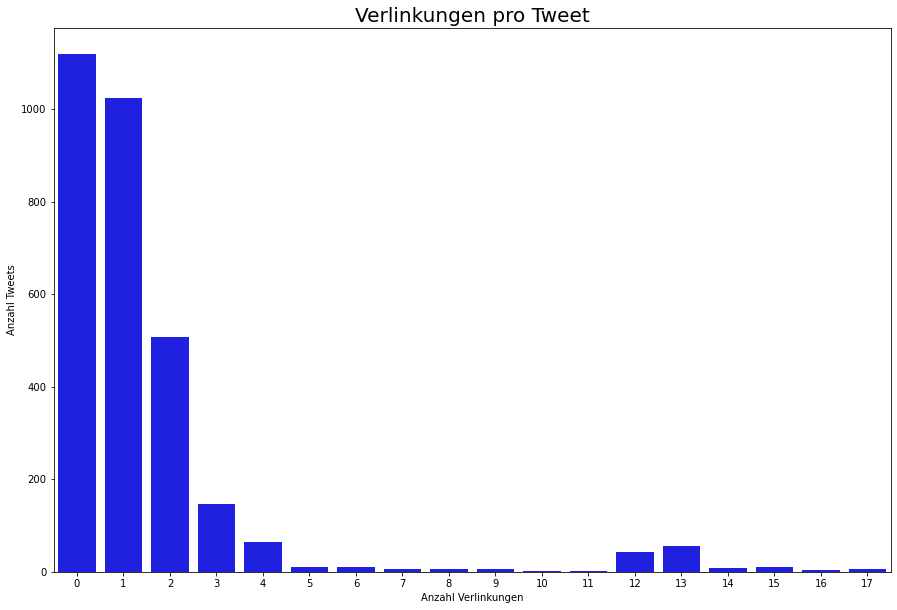

In [381]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(data = df
                   , x = "Verlinkung pro Tweet"
                   , color = "blue"
              )
ax.set(xlabel  = "Anzahl Verlinkungen"
        ,ylabel = "Anzahl Tweets")


plt.title('Verlinkungen pro Tweet',size=20)
plt.savefig("Verlinkung_pro_Tweet_Gesamt.png")
plt.show()

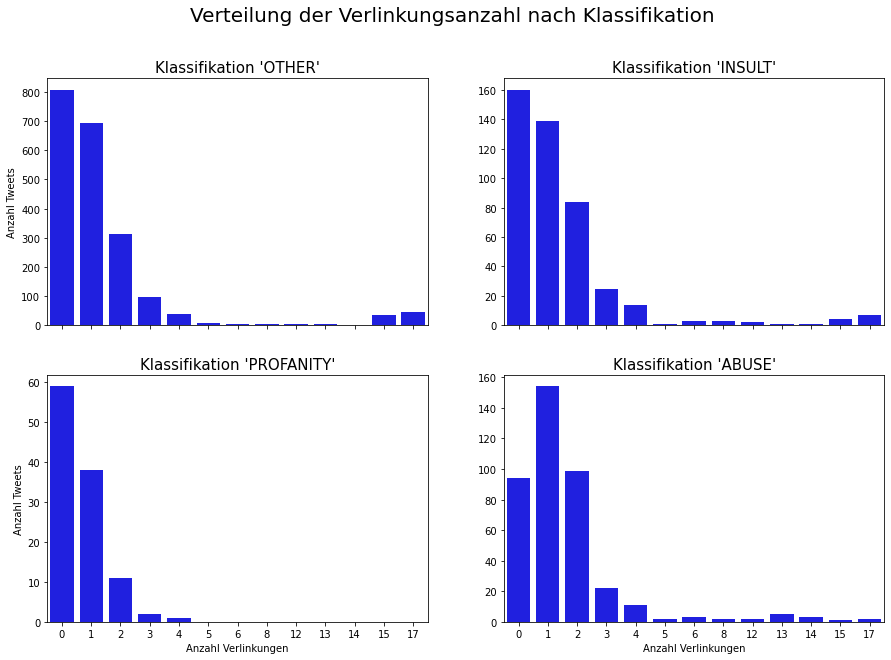

In [382]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Verteilung der Verlinkungsanzahl nach Klassifikation", fontsize=20)

ax0 = sns.countplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "Verlinkung pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,0]
              )

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.countplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "Verlinkung pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,1]
              )

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.countplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "Verlinkung pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,0]
              )

ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
ax2.set(xticklabels=[])
ax2.set(xlabel  = "Anzahl Verlinkungen"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.countplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "Verlinkung pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,1]
              )

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Anzahl Verlinkungen"
        ,ylabel = "")

plt.savefig("Verlinkung_pro_Tweet_Klassen.png")


plt.show()

### Anzahl Hashtags pro Tweet

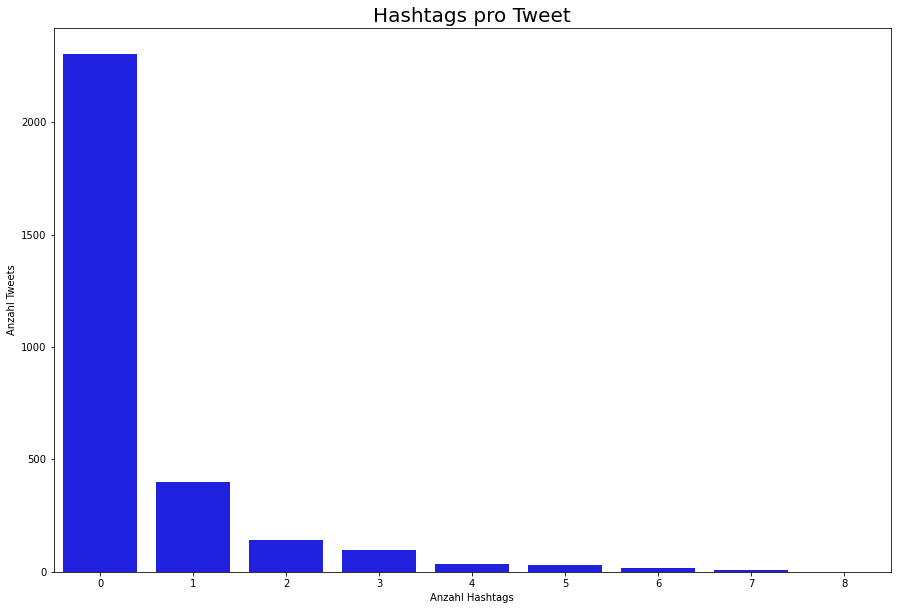

In [383]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(data = df
                   , x = "Hashtags pro Tweet"
                   , color = "blue"
              )
plt.title('Hashtags pro Tweet',size=20)

ax.set(xlabel  = "Anzahl Hashtags"
        ,ylabel = "Anzahl Tweets")

plt.savefig("Hashtags_pro_Tweet_Gesamt.png")

plt.show()

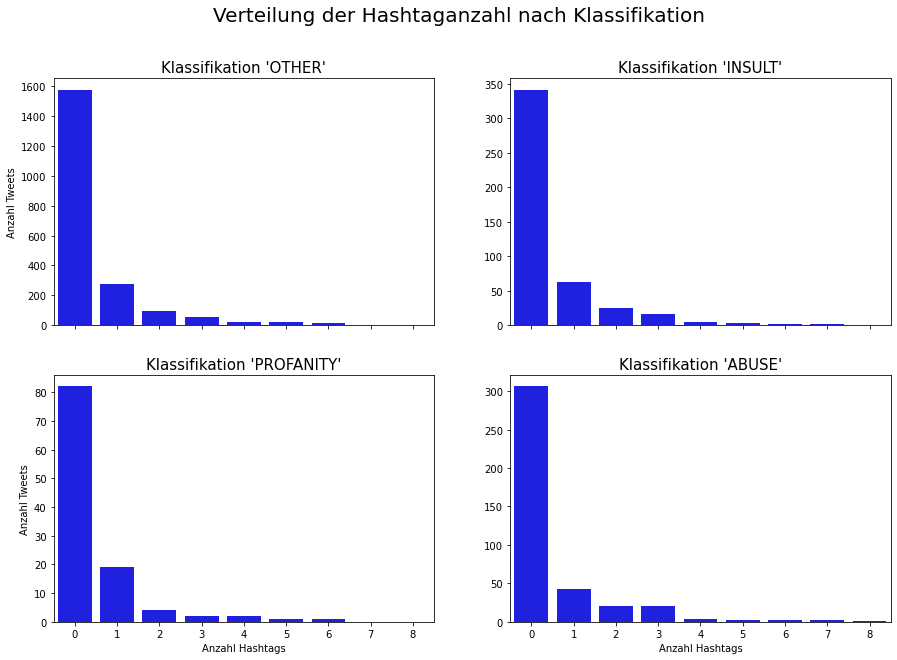

In [384]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Verteilung der Hashtaganzahl nach Klassifikation", fontsize=20)

ax0 = sns.countplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "Hashtags pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,0]
              )

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
# ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.countplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "Hashtags pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,1]
              )

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
# ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.countplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "Hashtags pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,0]
              )

ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
# ax2.set(xticklabels=[])
ax2.set(xlabel  = "Anzahl Hashtags"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.countplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "Hashtags pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,1]
              )

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Anzahl Hashtags"
        ,ylabel = "")

plt.savefig("Hashtags_pro_Tweet_Klassen.png")


plt.show()

### Anzahl utf Codes pro Tweet

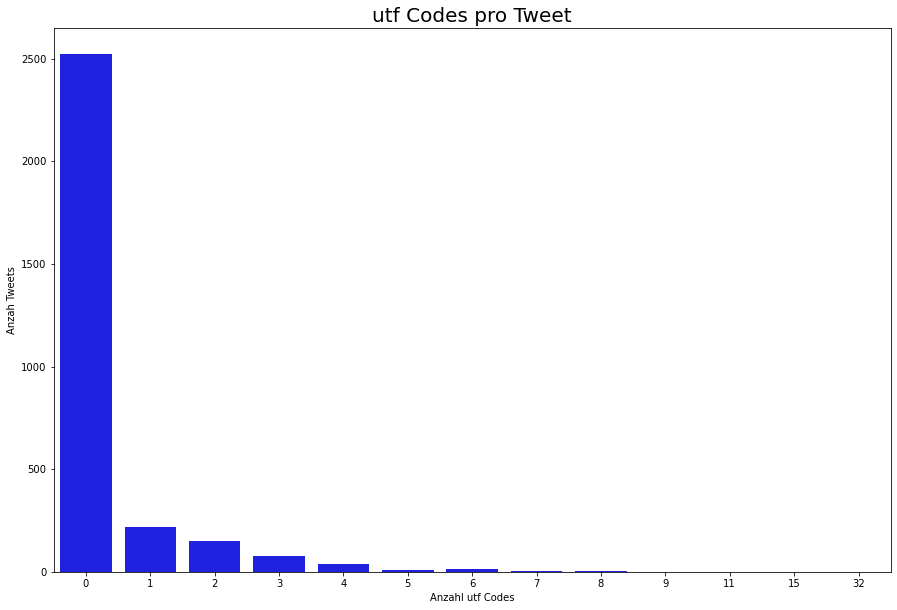

In [385]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(data = df
                   , x = "utf Codes pro Tweet"
                   , color = "blue"
              )

plt.title('utf Codes pro Tweet',size=20)

ax.set(xlabel  = "Anzahl utf Codes"
        ,ylabel = "Anzah Tweets")

plt.savefig("utf_pro_Tweet_Gesamt.png")

plt.show()

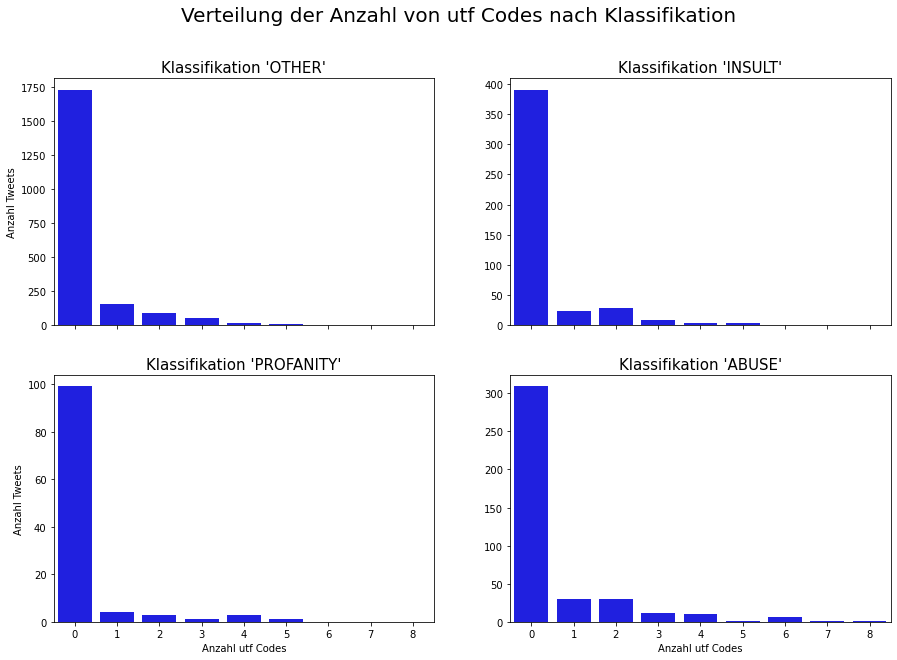

In [386]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Verteilung der Anzahl von utf Codes nach Klassifikation", fontsize=20)

ax0 = sns.countplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "utf Codes pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,0]
              )

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
# ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.countplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "utf Codes pro Tweet"
                    , color = "blue"
                    ,ax = axes[0,1]
              )

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
# ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.countplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "utf Codes pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,0]
              )

ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
# ax2.set(xticklabels=[])
ax2.set(xlabel  = "Anzahl utf Codes"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.countplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "utf Codes pro Tweet"
                    , color = "blue"
                    ,ax = axes[1,1]
              )

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Anzahl utf Codes"
        ,ylabel = "")

plt.savefig("utf_pro_Tweet_Klassen.png")

plt.show()

### Anzahl Emojis pro Tweet

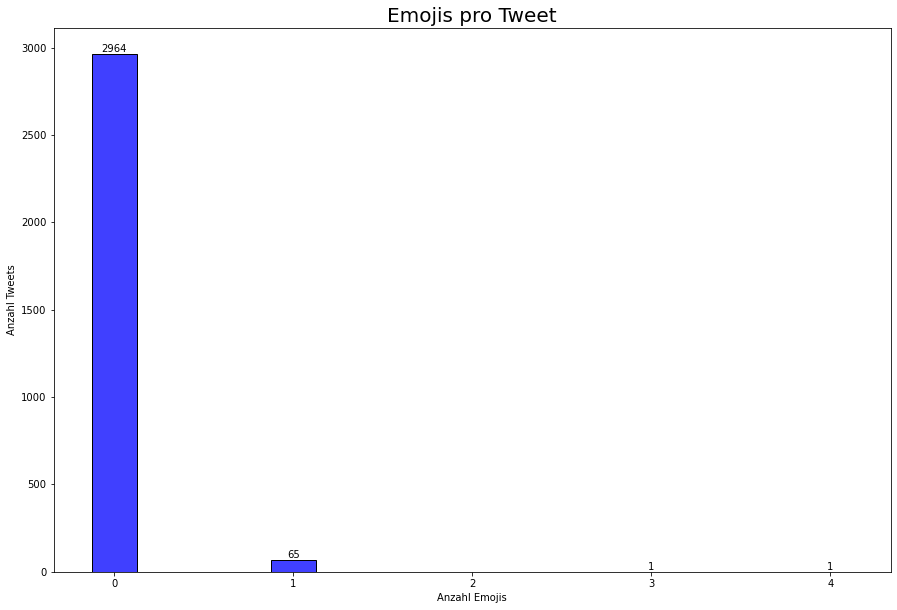

In [387]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.histplot(data = df
                   , x = "Emojis pro Tweet"
                   , color = "blue"
                   , stat = "count"
                   , binwidth = 1
                   , shrink = 0.25
                   , discrete = True
              )
plt.title('Emojis pro Tweet',size=20)

labels = [str(v) if v else '' for v in ax.containers[0].datavalues]
ax.bar_label(ax.containers[0], labels=labels)

ax.set(xlabel  = "Anzahl Emojis"
        ,ylabel = "Anzahl Tweets")

plt.savefig("Emojis_pro_Tweet_Gesamt.png")

plt.show()

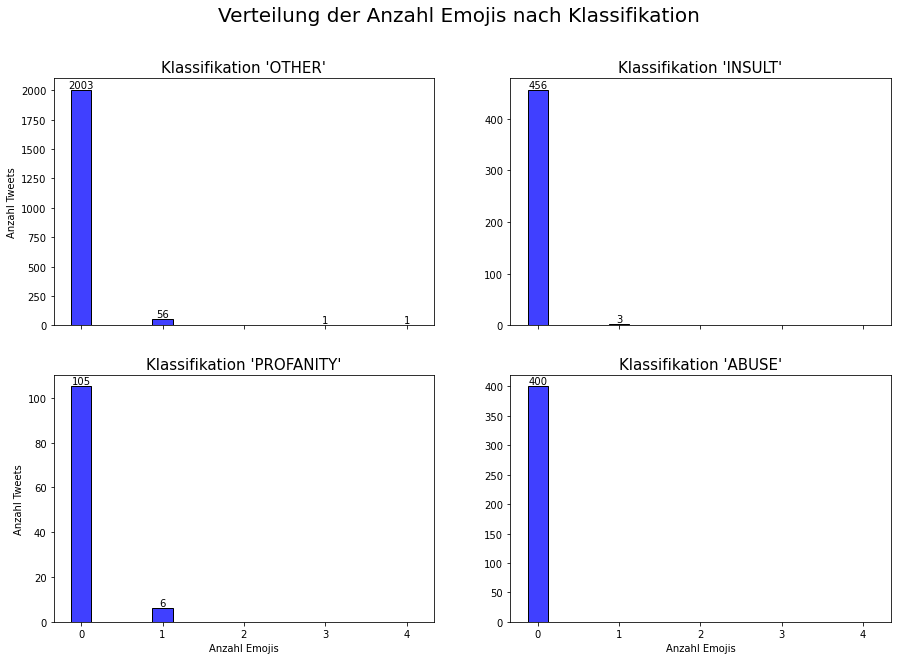

In [388]:
fig, axes = plt.subplots(nrows = 2
                         ,ncols = 2
                         ,figsize=(15,10)
                         ,sharex=True
                        )

fig.suptitle("Verteilung der Anzahl Emojis nach Klassifikation", fontsize=20)

ax0 = sns.histplot(data = df[df["granulareKlassifikation"]=="OTHER"]
                    , x = "Emojis pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    , shrink = 0.25
                    , discrete = True
                    ,ax = axes[0,0]
              )

labels = [str(v) if v else '' for v in ax0.containers[0].datavalues]
ax0.bar_label(ax0.containers[0], labels=labels)

ax0.set_title("Klassifikation 'OTHER'", fontsize = 15)
# ax0.set(xticklabels=[])
ax0.set(xlabel  = ""
        ,ylabel = "Anzahl Tweets")

ax1 = sns.histplot(data = df[df["granulareKlassifikation"]=="INSULT"]
                    , x = "Emojis pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    , shrink = 0.25
                    , discrete = True
                    ,ax = axes[0,1]
              )


labels = [str(v) if v else '' for v in ax1.containers[0].datavalues]
ax1.bar_label(ax1.containers[0], labels=labels)

ax1.set_title("Klassifikation 'INSULT'", fontsize = 15)
# ax1.set(xticklabels=[])
ax1.set(xlabel  = ""
        ,ylabel = "")

ax2 = sns.histplot(data = df[df["granulareKlassifikation"]=="PROFANITY"]
                    , x = "Emojis pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    , shrink = 0.25
                    , discrete = True
                    ,ax = axes[1,0]
              )

labels = [str(v) if v else '' for v in ax2.containers[0].datavalues]
ax2.bar_label(ax2.containers[0], labels=labels)


ax2.set_title("Klassifikation 'PROFANITY'", fontsize = 15)
# ax2.set(xticklabels=[])
ax2.set(xlabel  = "Anzahl Emojis"
        ,ylabel = "Anzahl Tweets")

ax3 = sns.histplot(data = df[df["granulareKlassifikation"]=="ABUSE"]
                    , x = "Emojis pro Tweet"
                    , color = "blue"
                    , stat = "count"
                    , binwidth = 1
                    , shrink = 0.25
                    , discrete = True
                    ,ax = axes[1,1]
              )

labels = [str(v) if v else '' for v in ax3.containers[0].datavalues]
ax3.bar_label(ax3.containers[0], labels=labels)

ax3.set_title("Klassifikation 'ABUSE'", fontsize = 15)
# ax3.set(xticklabels=[])
ax3.set(xlabel  = "Anzahl Emojis"
        ,ylabel = "")

plt.savefig("Emojis_pro_Tweet_Klassen.png")

plt.show()

## Analyse der qualitativen Merkmale

### Data Preparation

In [389]:
nltk.download('stopwords')
# Combine german stopwords from nltk with additional stopwords
german_stopwords1 = []
with open('./data/stop_words_german.txt', encoding="utf-8") as f:
    for line in f:
        line = line.replace('\n','')
        german_stopwords1.append(line)

german_stopwords2 = stopwords.words("german")

german_stopwords = german_stopwords1 + german_stopwords2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [390]:
# words in tweet as one string 
data = df
data["tweets_clean"] = [" ".join(word) for word in data["Wörter in Tweet"]] 

# drop unicode emojis and LBR
new_tweet_ls = []
for tweet in data.tweets_clean:
    tweet_sp = tweet.split()
    for word in tweet_sp:
        if any(x in word for x in ["000", "LBR", "lbr"]) :
            tweet = tweet.replace(word, "")
        
    new_tweet_ls.append(tweet)

data["tweets_clean"] = new_tweet_ls

# Create a word cloud for every category
wc_OTHER = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords=german_stopwords).generate(str(data[data["binaereKlassifikation"] == "OTHER"]["tweets_clean"].values))
wc_insult = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "INSULT"]["tweets_clean"].values))
wc_abuse = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "ABUSE"]["tweets_clean"].values))
wc_profanity = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "PROFANITY"]["tweets_clean"].values))



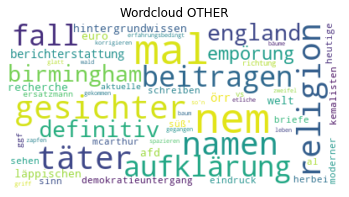

In [391]:
# plot word clouds
plt.imshow(wc_OTHER, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud OTHER")
plt.show()

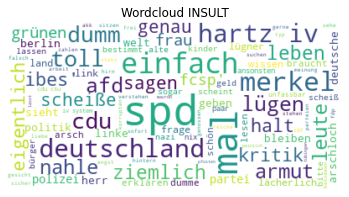

In [392]:
plt.imshow(wc_insult, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud INSULT")
plt.show()

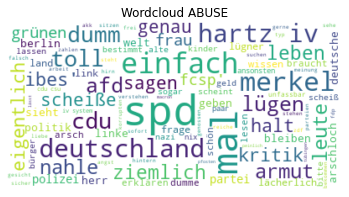

In [393]:
plt.imshow(wc_insult, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud ABUSE")
plt.show()

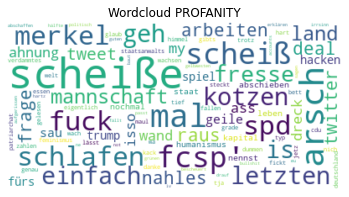

In [394]:
plt.imshow(wc_profanity, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud PROFANITY")
plt.show()

In [395]:
wc_OTHER_Ver = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords=german_stopwords).generate(str(data[data["binaereKlassifikation"] == "OTHER"]["Verlinkungen"].values))
wc_insult_Ver = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "INSULT"]["Verlinkungen"].values))
wc_abuse_Ver = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "ABUSE"]["Verlinkungen"].values))
wc_profanity_Ver = WordCloud(max_font_size=50, max_words=100, background_color="white",
                       stopwords=german_stopwords).generate(str(data[data["granulareKlassifikation"] == "PROFANITY"]["Verlinkungen"].values))



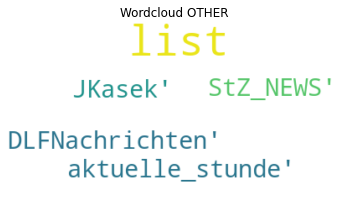

In [396]:
# plot word clouds
plt.imshow(wc_OTHER_Ver, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud OTHER")
plt.show()

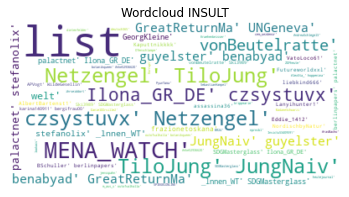

In [397]:
plt.imshow(wc_insult_Ver, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud INSULT")
plt.show()

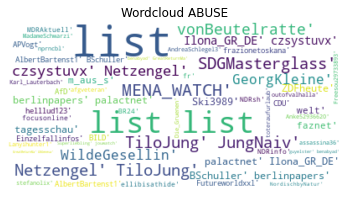

In [398]:
plt.imshow(wc_abuse_Ver, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud ABUSE")
plt.show()

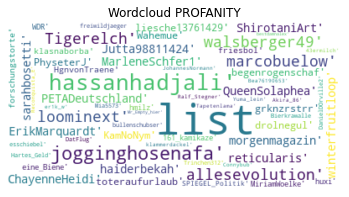

In [399]:
plt.imshow(wc_profanity_Ver, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud PROFANITY")
plt.show()

# Modellierung

## TFIDF-Vectorizer mit Random Forest Classifier 

### Data Preprocessing

In [400]:
# preprocess the tweets
def process_tweets(tweet : str):
    # all lowercase
    tweet = tweet.lower()
    # remove Sonderzeichen etc (based on Sonderzeichen.txt)
    tweet = re.sub('[^a-zA-ZäöüÄÖÜß]', " ", tweet)
    return tweet

data_pre = data
data_pre["tweets_clean"] = [process_tweets(tweet) for tweet in data_pre["tweet"]]

In [401]:
encoder = LabelEncoder()
data_pre['granulareKlassifikation'] = encoder.fit_transform(data_pre['granulareKlassifikation'])

### TFIDF Vectorizer

In [402]:
tfidf_vec = TfidfVectorizer()

In [403]:
df_train, df_test = train_test_split(data_pre,
 test_size = 0.2,
 random_state = 42)

X_train = tfidf_vec.fit_transform(df_train['tweets_clean'])
X_test = tfidf_vec.transform(df_test['tweets_clean'])
y_train = np.ravel(df_train['granulareKlassifikation'])
y_test = np.ravel(df_test['granulareKlassifikation'])

### Random Forest Classifier

In [404]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
rfc_human_readeable = encoder.inverse_transform(rfc_predictions)

### Evaluation

In [405]:
print(classification_report(y_test, rfc_predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

       ABUSE       0.88      0.08      0.15        84
      INSULT       1.00      0.03      0.06       105
       OTHER       0.67      1.00      0.80       399
   PROFANITY       0.25      0.05      0.09        19

    accuracy                           0.67       607
   macro avg       0.70      0.29      0.27       607
weighted avg       0.74      0.67      0.56       607



In [406]:
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == y_test[i]:
        acc += 1
accuracy = acc / len(rfc_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.6738056013179572


In [407]:
data_pre['granulareKlassifikation'] = encoder.inverse_transform(data_pre['granulareKlassifikation'] )

## Spacy-NLP

In [408]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()

In [409]:
data_pre = data_train
data_pre["tweets_clean"] = [process_tweets(tweet) for tweet in data_pre["tweet"]]

In [410]:
# create spacy docs with a nlp pipeline
# https://spacy.io/usage/processing-pipelines
tweet_docs = [nlp(tweet) for tweet in data_pre["tweets_clean"]]

In [411]:
# extract the generated lemmas for words that are no stopwords and have a length of more than two
# Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced
# form belongs to the language. This reduced form or root word is called a lemma.
tweet_words = [
    [
    word.lemma_ for word in doc if ((not word.is_stop) and (len(word) >= 3))
    ]
    for doc in tweet_docs]

## Word2Vec

In [412]:
# create a word2vec model (gensim)
# https://developpaper.com/gensim-model-parameters-of-word2vec/
# Window: refers to the window size of training. 8 means that the first 8 words and the last 8 words are considered 
word2vec = Word2Vec(tweet_words, min_count=3, sg=1, hs=0, negative=9,
                    ns_exponent=0.69, window=6, vector_size=60, epochs=80)

# train the model
word2vec.train(tweet_words, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

(1228168, 2290480)

In [413]:
# Remove tweets where there are no words in the word2vec model
def remove_nan_tweets(tweet_words, model):
    tweet_words_dict = {}
    for tweet in tweet_words:
        sum_occurr = 0
        for word in tweet:
            if word in model:
                sum_occurr +=1
        if sum_occurr > 0:
            tweet_words_dict[tweet_words.index(tweet)] = True

    return tweet_words_dict

tweet_words_dict = remove_nan_tweets(tweet_words, word2vec.wv.index_to_key)
    
# subset data_pre and tweet_words, only tweets where at least one word is in the word2vec model
data_pre = data_pre.iloc[list(tweet_words_dict.keys()), :]
data_pre = data_pre.reset_index()
tweet_words = [tweet_words[i] for i in list(tweet_words_dict.keys())]

In [414]:
# test word similarities
def test_word_sim(word_a, word_b):
    print(f'{word_a} | {word_b}: {word2vec.wv.similarity(word_a, word_b)}')
    
    
test_word_sim("CDU", "SPD")
test_word_sim("Korruption", "Europa")
test_word_sim("Merkel", "CDU")
test_word_sim("Flüchtling", "Terror")
test_word_sim("Witz", "Karte")

CDU | SPD: 0.6800945997238159
Korruption | Europa: 0.2711542546749115
Merkel | CDU: 0.483936607837677
Flüchtling | Terror: 0.4018997251987457
Witz | Karte: 0.3367817997932434


In [415]:
# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    # list of words in the word2vec model
    words = [word for word in words if word in word2vec.wv.index_to_key]
    # get the vectors
    vectors = np.array([word2vec.wv.get_vector(word) for word in words])
    # return the sum of all vectors devided by the amount of words from words in the model
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each tweet
tweet_vectors = []
for tweet in tweet_words:
    vec = get_com_vector(tweet)
    tweet_vectors.append(vec)


In [416]:
# function to preprocess and transform new tweets
def new_tweet_vector(tweet : str):
    prep_new = process_tweets(tweet)
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_tweet_v = get_com_vector(words_new)

    return new_tweet_v, words_new

In [417]:
# create tweet vectors of test tweets
new_tweet_v = []
words_new = []
for tweet in data_test.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_82849/2279988988.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return vector / len(words)


In [418]:
# Remove tweets where there are no words in the word2vec model  
tweet_words_dict = remove_nan_tweets(words_new, word2vec.wv.index_to_key)   

# subset data_test and tweet_words, only tweets where at least one word is in the word2vec model
data_test = data_test.iloc[list(tweet_words_dict.keys()), :]
data_test = data_test.reset_index()
new_tweet_v = [new_tweet_v[i] for i in list(tweet_words_dict.keys())]

## Random Forest

In [419]:
# Encode the classes
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["granulareKlassifikation"])

In [420]:
# Train a Random Forest
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict(new_tweet_v)

In [421]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

In [422]:
# calculate accuracy
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)    

In [423]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.916


In [424]:
# classification report
print(classification_report(data_test["granulareKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

       ABUSE       1.00      0.80      0.89        86
      INSULT       0.99      0.78      0.87       170
       OTHER       0.88      1.00      0.94       467
   PROFANITY       1.00      0.74      0.85        27

    accuracy                           0.92       750
   macro avg       0.97      0.83      0.89       750
weighted avg       0.93      0.92      0.91       750



## Kombination zweier aufeinander aufbauender Random Forest Classifier 

In [425]:
# Encode the classes
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["binaereKlassifikation"])
encoder.classes_

array(['OFFENSE', 'OTHER'], dtype=object)

In [426]:
# Train a Random Forest
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict(new_tweet_v)


In [427]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

In [428]:
# calculate accuracy
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["binaereKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)  

In [429]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.9146666666666666


In [430]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(data_test["binaereKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

     OFFENSE       0.97      0.80      0.88       283
       OTHER       0.89      0.99      0.94       467

    accuracy                           0.91       750
   macro avg       0.93      0.89      0.91       750
weighted avg       0.92      0.91      0.91       750



In [431]:
# Only train on offensive tweets
data_pre_gran = data_pre[data_pre["granulareKlassifikation"] != "OTHER"]
tweet_vectors_gran = [tweet_vectors[i] for i in data_pre_gran.index.values.tolist()]
data_pre_gran = data_pre_gran.reset_index(drop=True)

In [432]:
# create tweet vectors of test tweets
# only offencsive tweets
data_test_gran = data_test[data_test["granulareKlassifikation"] != "OTHER"]
data_test_gran = data_test_gran.reset_index(drop=True)
new_tweet_v = []
words_new = []
for tweet in data_test_gran.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

In [433]:
# Remove tweets where there are no words in the word2vec model  
tweet_words_dict = remove_nan_tweets(words_new, word2vec.wv.index_to_key)   

# subset data_test and tweet_words, only tweets where at least one word is in the word2vec model
data_test_gran = data_test_gran.iloc[list(tweet_words_dict.keys()), :]
data_test_gran = data_test_gran.reset_index(drop=True)
new_tweet_v_gran = [new_tweet_v[i] for i in list(tweet_words_dict.keys())]

In [434]:
encoder_gran = LabelEncoder()
y_transformed_gran = encoder_gran.fit_transform(data_pre_gran["granulareKlassifikation"])
encoder_gran.classes_

array(['ABUSE', 'INSULT', 'PROFANITY'], dtype=object)

In [435]:
# Train a Random Forest
rfc_gran = RandomForestClassifier()
rfc_gran.fit(tweet_vectors_gran, y_transformed_gran)
rfc_predictions_gran = rfc_gran.predict(new_tweet_v_gran)

In [436]:
# transform predictions to classes
encoder_dict_gran = dict(enumerate(encoder_gran.classes_.flatten(), 0))
rfc_predictions_gran = [encoder_dict_gran[x] for x in rfc_predictions_gran]

In [437]:
# calculate accuracy
acc = 0
for i in range(len(rfc_predictions_gran)):
    if rfc_predictions_gran[i] == data_test_gran["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions_gran)  

In [438]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.9151943462897526


In [439]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(data_test_gran["granulareKlassifikation"], rfc_predictions_gran))

              precision    recall  f1-score   support

       ABUSE       0.84      0.95      0.89        86
      INSULT       0.95      0.92      0.94       170
   PROFANITY       1.00      0.74      0.85        27

    accuracy                           0.92       283
   macro avg       0.93      0.87      0.89       283
weighted avg       0.92      0.92      0.92       283



In [440]:
def make_predictions(new_tweet_vector):
    # make binaere predictions
    rfc_predictions = rfc.predict([new_tweet_vector])

    encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
    rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

    if rfc_predictions[0] == "OTHER":
        return rfc_predictions[0]
    else:
        # make granulare predictions
        rfc_predictions_gran = rfc_gran.predict([new_tweet_vector])

        encoder_dict_gran = dict(enumerate(encoder_gran.classes_.flatten(), 0))
        rfc_predictions_gran = [encoder_dict_gran[x] for x in rfc_predictions_gran]
        return rfc_predictions_gran[0]

In [441]:
# create tweet vectors of test tweets
new_tweet_v = []
words_new = []
for tweet in data_test.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

In [442]:
combo_preds = [make_predictions(x) for x in new_tweet_v]

In [443]:
# calculate accuracy
acc = 0
for i in range(len(combo_preds)):
    if combo_preds[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(combo_preds) 

In [444]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.9146666666666666


## Fasttext Model

In [137]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()

In [138]:
data_pre = data_train

In [139]:
# create spacy docs with a nlp pipeline
# https://spacy.io/usage/processing-pipelines
tweet_docs = [nlp(tweet) for tweet in data_pre["tweets_clean"]]

In [140]:
# extract the generated lemmas for words that are no stopwords and have a length of more than two
# Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced
# form belongs to the language. This reduced form or root word is called a lemma.
tweet_words = [
    [
    word.lemma_ for word in doc if ((not word.is_stop) and (len(word) >= 3))
    ]
    for doc in tweet_docs]

In [102]:
# download fasttext model from https://fasttext.cc/docs/en/crawl-vectors.html
ft = load_facebook_model("/Users/jannis/cc.de.300.bin")

In [142]:
def print_similarity(first_word, second_word):
    print(f'{first_word} | {second_word} : {ft.wv.similarity(first_word, second_word)}')

In [143]:
print_similarity("CDU", "SPD")
print_similarity("Korruption", "Europa")
print_similarity("Merkel", "CDU")
print_similarity("Flüchtling", "Terror")
print_similarity("Witz", "Karte")

CDU | SPD : 0.9337738752365112
Korruption | Europa : 0.9197860360145569
Merkel | CDU : 0.6671952605247498
Flüchtling | Terror : 0.9448315501213074
Witz | Karte : 0.5414656400680542


In [144]:
# continue training pretrained model
ft.build_vocab(tweet_words, update=True)
ft.train(tweet_words, total_examples=len(tweet_words), epochs=10)

(110614, 286310)

In [145]:
print_similarity("CDU", "SPD")
print_similarity("Korruption", "Europa")
print_similarity("Merkel", "CDU")
print_similarity("Flüchtling", "Terror")
print_similarity("Witz", "Karte")

CDU | SPD : 0.9588697552680969
Korruption | Europa : 0.9722153544425964
Merkel | CDU : 0.8095645904541016
Flüchtling | Terror : 0.9796336889266968
Witz | Karte : 0.6926819086074829


In [146]:
# unique list of words
uni_tweet_words = list(ft.wv.key_to_index.keys())

In [147]:
# Remove tweets where there are no words in the fasttext model
def remove_nan_tweets(tweet_words, model):
    tweet_words_dict = {}
    for tweet in tweet_words:
        sum_occurr = 0
        for word in tweet:
            if word in model:
                sum_occurr +=1
        if sum_occurr > 0:
            tweet_words_dict[tweet_words.index(tweet)] = True

    return tweet_words_dict

tweet_words_dict = remove_nan_tweets(tweet_words, uni_tweet_words)
    
# subset data_pre and tweet_words, only tweets where at least one word is in the word2vec model
data_pre = data_pre.iloc[list(tweet_words_dict.keys()), :]
data_pre = data_pre.reset_index()
tweet_words = [tweet_words[i] for i in list(tweet_words_dict.keys())]

In [148]:
# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    # list of words in the word2vec model
    words = [word for word in words if word in uni_tweet_words]
    # get the vectors
    vectors = np.array([ft.wv[word] for word in words])
    # return the sum of all vectors devided by the amount of words from words in the model
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each tweet
tweet_vectors = []
for tweet in tweet_words:
    vec = get_com_vector(tweet)
    tweet_vectors.append(vec)

In [149]:
# function to preprocess and transform new tweets
def new_tweet_vector(tweet : str):
    prep_new = tweet
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_tweet_v = get_com_vector(words_new)

    return new_tweet_v, words_new

In [150]:
# create tweet vectors of test tweets
new_tweet_v = []
words_new = []
for tweet in data_test.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_78603/2157699331.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return vector / len(words)


In [151]:
# Remove tweets where there are no words in the word2vec model  
tweet_words_dict = remove_nan_tweets(words_new, uni_tweet_words)   

# subset data_test and tweet_words, only tweets where at least one word is in the word2vec model
data_test = data_test.iloc[list(tweet_words_dict.keys()), :]
data_test = data_test.reset_index()
new_tweet_v = [new_tweet_v[i] for i in list(tweet_words_dict.keys())]

In [152]:
# Encode the classes
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["granulareKlassifikation"])
encoder.classes_

array([0, 1, 2, 3])

In [153]:
y_transformed

array([2, 1, 1, ..., 2, 2, 2])

In [154]:
# Train a Random Forest
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict(new_tweet_v)

In [155]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

In [156]:
# evaluate predictions
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)  

In [157]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.9180977542932629


In [158]:
# classification report
print(classification_report(data_test["granulareKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        86
           1       1.00      0.78      0.88       171
           2       0.88      1.00      0.94       473
           3       1.00      0.74      0.85        27

    accuracy                           0.92       757
   macro avg       0.97      0.83      0.89       757
weighted avg       0.93      0.92      0.92       757



## Sentence Transformer

In [163]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()

In [164]:
# load pretrained transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# create tweet embeddings
tweet_vectors = model.encode(data_train["tweets_clean"])
new_tweet_v = model.encode(data_test["tweets_clean"])

In [170]:
# Encode the classes
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_train["granulareKlassifikation"])
encoder.classes_

array([0, 1, 2, 3])

In [171]:
# Train a Random Forest
rfc = RandomForestClassifier(random_state=42)
rfc.fit(tweet_vectors, y_transformed)

# make predictions
rfc_predictions = rfc.predict(new_tweet_v)

In [172]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

In [173]:
# evaluate predictions
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)  

In [174]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.9155672823218998


In [175]:
# classification report
print(classification_report(data_test["granulareKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        86
           1       0.99      0.77      0.87       171
           2       0.88      1.00      0.94       474
           3       1.00      0.74      0.85        27

    accuracy                           0.92       758
   macro avg       0.97      0.83      0.89       758
weighted avg       0.92      0.92      0.91       758

